In [1]:
import pandas as pd
import re
import ipycanvas
from datetime import datetime, timedelta
import matplotlib
import numpy as np
import math
from IPython.display import display, update_display, Markdown

In [2]:
class Progress:
    def __init__(self, name, count):
        self.name = name
        self.count = count
        display("Starting '" + name + "'", display_id=name)
        self.last_update = 0
        self.step = math.ceil(self.count/100) # Update when about 1% has elapsed.
    
    def update(self, value):
        if value != self.count and int(value - self.last_update) % self.step > 0:
            return # Don't update too often since that will slow down loops a lot!
        self.last_update = value
        p = (value+1)/self.count
        message = f"{self.name}: {int(100*p)}% complete."
        update_display(message, display_id=self.name)
        
    def complete(self):
        self.update(self.count)

Load GTFS data
==

This can take a minute - stop_times is 500Mb.

In [3]:
files = [
    "agency",
    "calendar",
    "calendar_dates",
    "routes",
    "shapes",
    "stop_times",
    "stops",
    "transfers",
    "trips"
]

for name in files:
    print("Reading " + name)
    globals()[name] = pd.read_csv(name + ".txt")
    
    
print("Parsing dates")

def parse_dates(table, field):
    table[field] = pd.to_datetime(table[field], format="%Y%m%d")

parse_dates(calendar, "start_date")
parse_dates(calendar, "end_date")
parse_dates(calendar_dates, "date")
    
print("Complete")

Reading agency
Reading calendar
Reading calendar_dates
Reading routes
Reading shapes
Reading stop_times


C:\Users\Kieran\anaconda3\envs\general\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Reading stops
Reading transfers
Reading trips
Parsing dates
Complete


Minor note: direction is stored as numbers somtimes. 

In [4]:
DIRECTION_OUTBOUND = 0
DIRECTION_INBOUND = 1

Overview
==

The sections contains a brief overview of each table, with little bits of analysis.

Agency
--

The 5 different agencies covered by GTFS. <br>At minimum, we need Dublin Bus and can ignore the others. But we may want to include info on the others too.

In [5]:
agency

,agency_id,agency_name,agency_url,agency_timezone,agency_lang
0,03C,GoAhead Commuter,https://www.transportforireland.ie,Europe/Dublin,EN
1,978,Dublin Bus,https://www.transportforireland.ie,Europe/Dublin,EN
2,01,Bus Éireann,https://www.transportforireland.ie,Europe/Dublin,EN
3,01X,Expressway,https://www.transportforireland.ie,Europe/Dublin,EN
4,03,Go-Ahead,https://www.transportforireland.ie,Europe/Dublin,EN


Calendar
--

A calendar is made up of 'services', which run on certain days of the week from a start date to an end date.

In [6]:
print("Count:", len(calendar))
calendar.head()

Count: 85


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,1,0,0,0,0,0,0,1,2021-06-23,2021-12-18
1,1#1,1,0,0,0,0,0,1,2021-06-23,2021-12-04
2,1#2,0,0,0,0,0,0,1,2021-06-23,2021-07-31
3,10,0,0,1,0,0,0,0,2021-06-23,2021-12-04
4,10#1,0,1,0,0,0,0,0,2021-06-23,2021-12-18


Note: service_id is the unique ID in calendar.

Note 2: all dates are in 2021

In [7]:
for field in ["start_date", "end_date"]:
    display(calendar[field].map(lambda x: x.date().year).value_counts())

2021    85
Name: start_date, dtype: int64

2021    85
Name: end_date, dtype: int64

The cell below contains an overcomplicated function for visualizing date data

In [8]:
def plot_calendar(color_map):
    
    # Figure out the scale factors
    min_value = max_value = None
    dt = datetime(2021, 1, 1)
    while dt.date().year == 2021:
        value = color_map(dt)
        if min_value is None or value < min_value: 
            min_value = value
        if max_value is None or value> max_value:
            max_value = value
        dt += timedelta(days=1)
    if min_value == max_value:
        min_value = max_value - 1
        
    # Metrics for drawing
    scale = 3
    size = 2*scale; margin = scale; month_margin = 4*scale;
    gap = size + margin; month_gap = gap*7 + 2*month_margin, gap*5 + 2*month_margin

    # Create the canvas
    canvas = ipycanvas.Canvas(width=int(month_gap[0]*4.1), height=int(month_gap[1]*3.1))
    display(canvas)
    
    def draw_day(x, y, dt):
        
        try:
            p = float(color_map(dt))
        except:
            raise ValueError("Error while applying color map! (Is it a function that returns a float?)")

        # Normalize, then convert to a percentage.
        p = (p - min_value) / (max_value - min_value)
        p = int(max(0, min(p, 1)) * 100)
        
        canvas.fill_style=f"hsl(0,{p}%,50%)"
        canvas.fill_rect(x, y, size)
    
    def draw_month(x, y, dt):

        month = dt.date().month
        for i in range(6):
            for j in range(7):
                if dt.weekday() != j: continue
                if dt.date().month != month: break
                draw_day(x + j*gap, y + i*gap, dt)
                dt += timedelta(days=1)

        return dt

    def draw_year(x, y, dt):

        year = dt.date().year
        for i in range(4):
            for j in range(4):
                if dt.date().year != year:
                    break
                dt = draw_month(x + j*month_gap[0], y + i*month_gap[1], dt)

    with ipycanvas.hold_canvas(canvas):
        draw_year(0, 0, datetime(2021, 1, 1))

First, are some services localized in time?

In [9]:
tally = {}

dt = calendar.start_date.min()
final_end = calendar.end_date.max()
while dt <= final_end:
    for start, end in zip(calendar.start_date, calendar.end_date):
        if dt >= start and dt <= end:
            key = dt.to_pydatetime()
            if key not in tally:
                tally[key] = 0
            tally[key] += 1
    dt += timedelta(days=1)

plot_calendar(lambda x: tally.get(x, 0))

Canvas(height=213, width=356)

Relatively speaking, not really.
<br>But the calendar as a whole is much more local than I had expected - it begins in May and ends some time around Dec. 
<br>I assume this has to do with when I downloaded it.

Calendar Dates
--

As specified at: https://developers.google.com/transit/gtfs/reference#calendar_datestxt
<br>This table defines extra specific days on which a service has been added or removed. 

In [10]:
print("Count:", len(calendar_dates))
calendar_dates.head()

Count: 850


,service_id,date,exception_type
0,1,2021-08-01,2
1,1,2021-08-08,2
2,1,2021-08-15,2
3,1,2021-08-22,2
4,1,2021-08-29,2


First off, note that exceptiont type is only ever 2.
<br>2 means removed.

In [11]:
calendar_dates.exception_type.value_counts()

2    850
Name: exception_type, dtype: int64

Seconly, there are no duplicates. This also means (since exception type is constant) that each service has at most one entry for a given day. This is just a consistency check, it's what we'd expect. A service can't be both added and removed at the same time from a day.

In [12]:
len(calendar_dates) - len(calendar_dates[["service_id", "date"]].drop_duplicates())

0

Finally, a look at where these days are placed.
<br>There are a quite a few for every Monday. I don't know why that would be.

In [13]:
mapper = lambda dt: len(calendar_dates[calendar_dates.date == dt])
plot_calendar(mapper)

Canvas(height=213, width=356)

Routes
--

Strictly speaking, these are names given to collections of related paths on which trips can take place.
<br> Many of the interesting questions we might have about routes or shapes or stops will need all of these tables to be combined via trip & stop_times - this kept in a separate section.

In [14]:
print("Count:", len(routes))
routes.head(5)

Count: 548


,route_id,agency_id,route_short_name,route_long_name,route_type
0,10-100-e20-1,01,100,Drogheda Bus Station -,3
1,10-101-e20-1,01,101,Busáras - Drogheda Bus Station,3
2,10-103-e20-1,01,103,Dublin (Beresford Place) - Tayto Park,3
3,10-104-e20-1,01,104,Bus Stop at Train Station - Hastings Green Rou...,3
4,10-105-e20-1,01,105,Hospital Car Park - Drogheda Bus Station,3


A short name can refer to 1-3 routes. Usually 1 or 2.
<br>I don't yet know the difference between them.

Q: Do routes of the Dublin Bus system share short names with the other bus systems?

In [19]:
def check(name):
    agencies = set(routes.agency_id[routes.route_short_name == name])
    return len(agencies) > 1 and "978" in agencies

routes[routes.route_short_name.apply(check)].sort_values("route_short_name").head(10)

,route_id,agency_id,route_short_name,route_long_name,route_type
351,60-120-d12-1,978,120,Merrion Road RDS - River Road,3
350,60-120-b12-1,978,120,Merrion Road RDS - River Road,3
255,17-120-cm1-1,03C,120,Dublin - Edenderry,3
17,10-13-e20-1,01X,13,Limerick Bus Station - Tralee Bus Station,3
359,60-13-d12-1,978,13,Harristown Bus Garage - Business Park Bus Term...,3
358,60-13-b12-1,978,13,Harristown Bus Garage - Business Park Bus Term...,3
356,60-130-b12-1,978,130,Talbot Street - Clontarf Castle,3
266,17-130-cm1-1,03C,130,Dublin - Athy,3
357,60-130-d12-1,978,130,National Lottery Head Quarters - Clontarf Castle,3
18,10-14-e20-1,01X,14,Limerick Bus Station - Killarney Bus Station,3


Answer: Yes.

Shapes
--

A route is associated with 1 or more shapes. Each trip along a route is associated with exactly one of these shapes.

In [16]:
print("Count:", len(shapes))
shapes.head(5)

Count: 1017790


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,10-100-e20-1.229.O,53.711610,-6.353111,1,0.00
1,10-100-e20-1.229.O,53.711849,-6.352845,2,31.85
2,10-100-e20-1.229.O,53.712178,-6.352604,3,71.73
3,10-100-e20-1.229.O,53.712258,-6.352571,4,80.94
4,10-100-e20-1.229.O,53.712468,-6.352745,5,106.85


Notice that the shape id is a mix of a route id, a direction, and another number.
<br>We could separate these out with regex, but I think the 'proper' way to make the link is via the trips table, which binds a route to a time, a shape, and some stops.

**Note:** 1017790 is the number of points across all paths, not the number of paths!
<br>There are 2236 paths

In [17]:
len(shapes.shape_id.unique())

2236

With this in mind, how many shapes per route?

For many (41%) routes, 2. One for inbound, one for outbound.
<br>But for the remaining 60%, there  can easily be 5-10 paths, and some rare ones have 30-40 paths.

41% of routes have the standard 2 paths


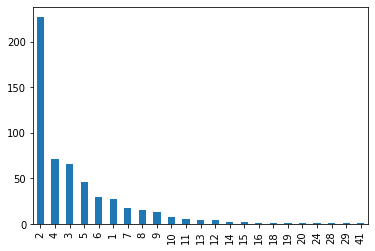

In [18]:
shape_ids = pd.Series(shapes.shape_id.unique())

def count_paths(route_id):
    mask = shape_ids.apply(lambda x: route_id in x)
    # Count up the number of positives
    return sum(mask)
    
counts = routes.route_id.apply(count_paths).value_counts()
counts.plot(kind="bar")
print(f"{round(counts[2]/counts.sum()*100)}% of routes have the standard 2 paths")

Stop Times
==

In [19]:
print("Count:", len(stop_times))
stop_times.head(5)

Count: 6019184


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,1143.y1006.17-130-cm1-1.82.I,06:10:00,06:10:00,8260B136421,1,NaN,0,0,0.00
1,1143.y1006.17-130-cm1-1.82.I,06:18:00,06:18:00,8260B1324001,2,NaN,0,0,7572.44
2,1143.y1006.17-130-cm1-1.82.I,06:25:00,06:25:00,8260B1408801,3,NaN,0,0,15897.87
3,1143.y1006.17-130-cm1-1.82.I,06:32:00,06:32:00,8260B136431,4,NaN,0,0,22830.16
4,1143.y1006.17-130-cm1-1.82.I,06:34:00,06:34:00,8260B136391,5,NaN,0,0,24442.99


This is the biggest table in the dataset, with 6 million entries. I'll come back to it, since the trip and stop tables are prerequisites for understanding this one.

Stops
==

In [20]:
print("Count:", len(stops))
stops.head(5)

Count: 10001


,stop_id,stop_name,stop_lat,stop_lon
0,7010B158131,"Ulsterbus Depot, stop 158131",54.996629,-7.317866
1,7010B158241,"Magee Campus, stop 158241",55.004476,-7.321782
2,704000000229,Killeen Bridge,54.131009,-6.346082
3,7040B107131,"Cullaville, stop 107131",54.062045,-6.643525
4,7040B139481,"Newry, stop 139481",54.168253,-6.339098


There are 10,000 stops in Ireland...
<br>Luckily, we only have to worry about Dublin. I'm hoping there are less there.

We can do a quick bounding box filter to get an idea of the difference...

In [21]:
lat = stops.stop_lat
lon = stops.stop_lon

lat_bounded = (lat > 53.174) & (lat < 53.457)
lon_bounded = (lon > -6.495) & (lon < -6.04)

sum(lat_bounded & lon_bounded)

4370

And that is still over 4000. Hopefully this will be narrowed further when we consider Dublin Bus only? We'll see later.

Q: Are stops ever both outbound and inbound for the same route? 

In [22]:
progress = Progress("Indexing trip direction and route", len(trips))
trip_direction = dict()
trip_route = dict()
for i in trips.index:
    trip_id = trips.trip_id[i]
    direction_id = trips.direction_id[i]
    route_id = trips.route_id[i]
    trip_direction[trip_id] = direction_id
    trip_route[trip_id] = route_id
    progress.update(i)
progress.complete()

progress = Progress("Collecting stops for inbound and outbound", len(stop_times))
route_outbound_stops = dict()
route_inbound_stops = dict()
for route_id in routes.route_id:
    route_outbound_stops[route_id] = set()
    route_inbound_stops[route_id] = set()
for i in stop_times.index:
    trip_id = stop_times.trip_id[i]
    stop_id = stop_times.stop_id[i]
    route_id = trip_route[trip_id]
    direction_id = trip_direction[trip_id]
    if direction_id == DIRECTION_OUTBOUND:
        route_outbound_stops[route_id].add(stop_id)
    else:
        route_inbound_stops[route_id].add(stop_id)
    progress.update(i)
progress.complete()

display("Comparing inbound and outbound stops")
result = set()
route_count = 0
for route_id in routes.route_id:
    outbound = route_outbound_stops[route_id]
    inbound = route_inbound_stops[route_id]
    common = inbound & outbound
    result.update(common)
    if len(common) > 0: route_count += 1
print(f"Stops in a single route's outbound & inbound: {len(result)}/{len(stops)}")
print(f"Routes with a common stop in inbound and outbound: {route_count}/{len(routes)}")

'Indexing trip direction and route: 100% complete.'

'Collecting stops for inbound and outbound: 100% complete.'

'Comparing inbound and outbound stops'

Stops in a single route's outbound & inbound: 568/10001
Routes with a common stop in inbound and outbound: 435/548


Conclusion: Yes, some stops appear in both, but not many. So it makes sense in the database to have separate stop lists for inbound and outbound, though there will be a small overlap there.
<br>(Also, while few stops are involved, almost all the routes are involved, which in interesting)

Transfers
==

In [20]:
print("Count:", len(transfers))
transfers.head(5)

Count: 7151


,from_stop_id,to_stop_id,transfer_type,min_transfer_time
0,8250DB003073,8250DB003040,2,60.0
1,8250DB003073,8250DB003039,2,240.0
2,8380B1553801,8380B1553501,2,0.0
3,8430B155401,8430B255231,2,0.0
4,8430B255231,8430B155401,2,0.0


This is an interesting table, but **not relevant** to us.

It describes links between nearby stops where users might switch routes.

Figuring this out is a **routing** responsibility, which is beyond the scope of the app. We will let google do this!
<br>(Gavin explicitly brought this up at one of the presentations)

Trips
==

In [21]:
print("Count:", len(trips))
trips.head(5)

Count: 184095


,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,10-100-e20-1,1,1954979.1.10-100-e20-1.232.I,10-100-e20-1.232.I,- Drogheda Bus Station,1
1,10-100-e20-1,1,1954981.1.10-100-e20-1.231.O,10-100-e20-1.231.O,Drogheda Bus Station -,0
2,10-100-e20-1,1,1954982.1.10-100-e20-1.232.I,10-100-e20-1.232.I,- Drogheda Bus Station,1
3,10-100-e20-1,1,1954983.1.10-100-e20-1.231.O,10-100-e20-1.231.O,Drogheda Bus Station -,0
4,10-100-e20-1,1,1954984.1.10-100-e20-1.232.I,10-100-e20-1.232.I,- Drogheda Bus Station,1


That is a lot of trips.

In [23]:
trips2 = trips.copy()
# This takes a few mins! Hence it is commented out.
#trips2["agency_id"] = trips.route_id.apply(lambda x: routes[routes.route_id == x].agency_id.values[0])
# sum(trips2.agency_id == "978")

Only 28,000 trips are from Dublin Bus.

Q: How often are alternative paths used?

In [25]:
tallies = list()
for route_id in routes.route_id:
    route_trips = trips[trips.route_id == route_id]
    shape_counts = route_trips.groupby("shape_id").count().route_id.sort_values(ascending=False).values
    for i, value in enumerate(shape_counts):
        if len(tallies) <= i:
            tallies.append(0)
        tallies[i] += value  

84.94364322768136% of trips are along the main path for a route


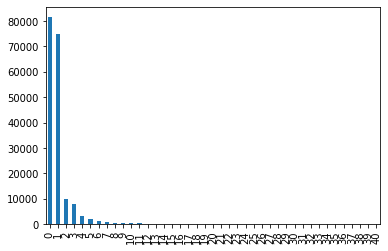

In [26]:
pd.Series(tallies).plot(kind="bar")

main_portion = (tallies[0] + tallies[1]) / sum(tallies)
print(f"{main_portion*100}% of trips are along the main path for a route")

The results come in pairs, as expected, for incoming and outgoing

On a minor note, there must be a number of routes for which the number of ingoing vs outgoing must be imbalanced.

More significantly, we see that most (85%) of trips are along the main segment of a route.

15% is still quite significant though!

Q: Is there a 1-1 correspondence between shapes and collections of stops?
<br>(At least within a route?)

In [65]:
def check_shape_stops():
    
    # First build a lookup dictionary for trip stops.
    
    trip_stops = dict()
    for trip_id in trips.trip_id:
        trip_stops[trip_id] = set()
    
    section = stop_times.index[:]
    progress = Progress("Building trip stop lookup", len(section))
    for i in section:
        stop_id = stop_times.stop_id[i]
        trip_id = stop_times.trip_id[i]
        trip_stops[trip_id].add(stop_id)
        if i % 10000 == 0:
            progress.update(i)
    progress.complete()
    
    # For each trip, note the shape ID and find the stops. 
    # If we've not encountered the shape ID before, note the stops
    # If we have, check that the stops match
    
    pass_count = 0
    fail_count = 0
    print_limit = 5
    
    shape_stops = dict()
    
    progress = Progress("Checking stops against shapes", len(trips.index))
    for i in trips.index:

        shape_id = trips.shape_id[i]
        trip_id = trips.trip_id[i]
        current_stops = trip_stops[trip_id]

        if shape_id not in shape_stops:
            shape_stops[shape_id] = current_stops
        else:
            if shape_stops[shape_id] != current_stops:
                fail_count += 1
            else:
                pass_count += 1

        if i % 1000 == 0:
            progress.update(i)
    progress.complete()
    print("Passes:", pass_count)
    print("Fails:", fail_count)
    
# This takes a few minutes to run, so its commented out for now.
#check_shape_stops()

Building trip stop lookup: 100% complete.

Checking stops against shapes: 100% complete.

Passes: 181859
Fails: 0


So unique shapes do correspond to unique sets of stops, which is neat.

Q: Is there a link between route variants and services?
(Case study: 46a)

In [56]:
def get_services_by_variant(route_short_name):
    
    service_routes = dict()
    
    variants = routes[routes.route_short_name == route_short_name].route_id.values
    
    for variant in variants:
        
        route_services = set()
        for i in trips[trips.route_id == variant].index:
            route_services.add(trips.service_id[i])
            
        for service in route_services:
            if service not in service_routes:
                service_routes[service] = set()
            service_routes[service].add(variant)
    
    return service_routes

In [59]:
result = get_services_by_variant("46A")
for key in result:
    print(str(key) + ": ", end="")
    print(", ".join(result[key]))

y1003#1: 60-46A-b12-1
y1004#1: 60-46A-b12-1
y1005#2: 60-46A-b12-1
y1005#1: 60-46A-d12-1
y1006#1: 60-46A-d12-1


For the 46A, yes! There is no overlap at all.
<br>Does the same hold in general?

In [65]:
count = 0
silence_limit = 5 # Don't give a flood of messages

route_names = routes.route_short_name.unique()

for route_name in route_names:
    
    result = get_services_by_variant(route_name)
    for key, value in result.items():
        # print(str(key) + ": ", end="")
        # print(", ".join(result[key]))
        if len(value) > 1:
            count += 1
    
print("Count of when a route has multiple variants for a service: ", count)


Count of when a route has multiple variants for a service:  0


Apparently it does. I find this a tad suspect (I could have abug in my code), and wouldn't rely on it, but it does help provide a reason for why a single route short name might correspond to multiple routes.

In [33]:
stop_times[stop_times.trip_id == "1143.y1006.17-130-cm1-1.82.I"]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,1143.y1006.17-130-cm1-1.82.I,06:10:00,06:10:00,8260B136421,1,NaN,0,0,0.00
1,1143.y1006.17-130-cm1-1.82.I,06:18:00,06:18:00,8260B1324001,2,NaN,0,0,7572.44
2,1143.y1006.17-130-cm1-1.82.I,06:25:00,06:25:00,8260B1408801,3,NaN,0,0,15897.87
3,1143.y1006.17-130-cm1-1.82.I,06:32:00,06:32:00,8260B136431,4,NaN,0,0,22830.16
4,1143.y1006.17-130-cm1-1.82.I,06:34:00,06:34:00,8260B136391,5,NaN,0,0,24442.99
5,1143.y1006.17-130-cm1-1.82.I,06:37:00,06:37:00,8260B136381,6,NaN,0,0,25765.36
6,1143.y1006.17-130-cm1-1.82.I,06:40:00,06:40:00,8260B136371,7,NaN,0,0,28060.98
7,1143.y1006.17-130-cm1-1.82.I,06:43:00,06:43:00,8260B136361,8,NaN,0,0,31887.21
8,1143.y1006.17-130-cm1-1.82.I,06:48:00,06:50:00,8260B1370001,9,NaN,0,0,34646.87
9,1143.y1006.17-130-cm1-1.82.I,06:51:00,06:51:00,8260B1042001,10,NaN,0,0,34945.86
